### References
https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
https://www.datasciencecentral.com/profiles/blogs/stock-price-prediction-using-lstm-long-short-term-memory

### Step 1. Importing Required Libraries

In [24]:
# !pip install keras
# !pip install tensorflow 
# !pip install pandas_datareader -U

In [25]:
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from math import sqrt
import math

# Data reader
from pandas_datareader import data
from matplotlib.ticker import FuncFormatter

#Plotting and Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# render the figures in this notebook 
%matplotlib inline
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf

#For scaling data
from sklearn.preprocessing import MinMaxScaler

#Keras modules for building LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Scikit-Learn for Modeling
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

### Step 2. Loading the Dataset

In [26]:
# Input tickers here
tickers = ['INTC']
start_date = '2016-11-01'
end_date = '2021-11-01'

# User pandas_reader.data.DataReader to load data
df = data.DataReader(tickers, 'yahoo', start_date, end_date)
df.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,INTC,INTC,INTC,INTC,INTC,INTC
Date,,,,,,
2016-11-01,30.157335,34.520000,35.160000,34.270000,34.900002,25368200.0
2016-11-02,30.227221,34.599998,34.900002,34.470001,34.599998,21416400.0
2016-11-03,29.866329,33.930000,34.520000,33.869999,34.450001,19400000.0
2016-11-04,29.584665,33.610001,33.930000,33.419998,33.529999,21914700.0
2016-11-07,30.535307,34.689999,34.750000,34.150002,34.240002,19296600.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2016-11-01 to 2021-11-01
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, INTC)  1259 non-null   float64
 1   (Close, INTC)      1259 non-null   float64
 2   (High, INTC)       1259 non-null   float64
 3   (Low, INTC)        1259 non-null   float64
 4   (Open, INTC)       1259 non-null   float64
 5   (Volume, INTC)     1259 non-null   float64
dtypes: float64(6)
memory usage: 68.9 KB


In [28]:
df.index

DatetimeIndex(['2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-07', '2016-11-08', '2016-11-09', '2016-11-10',
               '2016-11-11', '2016-11-14',
               ...
               '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22',
               '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28',
               '2021-10-29', '2021-11-01'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [29]:
fig = px.line(df['Close'])

fig.update_layout(title_text='Stock Prices of APPLE',font=dict(size=12),
                 xaxis_title_text="Date", yaxis_title_text="Close")
fig.show()

### Feature Scaling
Feature scaling and normalizing data are the best way to reduce the error rate and improve the accuracy of the model. There are various types of data in a given data set. Here, we all selected features on the same scale. Therefore, none of the features are dominating others. 

In our case, we’ll use Scikit- Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.

In [30]:
#make df into numpy array
close = df['Close']
close_array=close.values
close_array

array([[34.52000046],
       [34.59999847],
       [33.93000031],
       ...,
       [48.08000183],
       [49.        ],
       [49.54999924]])

In [31]:
#scale the features
sc = MinMaxScaler(feature_range = (0, 1))
scaled_close = sc.fit_transform(close_array)
scaled_close

array([[0.0302771 ],
       [0.03256211],
       [0.01342477],
       ...,
       [0.41759503],
       [0.44387318],
       [0.45958295]])

In [32]:
#Display the scaled features as dataframe
df_scaled_close=pd.DataFrame(data=scaled_close, 
                                 index=df.index, 
                                 columns=['Close'])
df_scaled_close.head()

,Close
Date,
2016-11-01,0.030277
2016-11-02,0.032562
2016-11-03,0.013425
2016-11-04,0.004285
2016-11-07,0.035133


In [33]:
# df_close = df_scaled_dataframe['Close']
# df_close.head() 

### Creating train and test sets

In [34]:
#array
close_dataset = df_scaled_close.values 
close_dataset

array([[0.0302771 ],
       [0.03256211],
       [0.01342477],
       ...,
       [0.41759503],
       [0.44387318],
       [0.45958295]])

In [35]:
# train_data_length = math.ceil(len(close_dataset)*0.8)
# train_data_length

train = close_dataset[0:int(len(close_dataset)*0.8)]

#this valid is noralised actual close price 
valid = close_dataset[int(len(close_dataset)*0.8):]

### Creating Data with Timesteps
 
LSTMs expect our data to be in a specific format, usually a 3D array. We start by creating data in 60 timesteps and converting it into an array using NumPy. Next, we convert the data into a 3D dimension array with X_train samples, 60 timestamps, and one feature at each step.

In [36]:
X_train = []
y_train = []

# changed to 180 days - yao
for i in range(180, len(train)):
    # predict stock price based on past 6 months of data
    X_train.append(close_dataset[i-180:i])
    y_train.append(close_dataset[i])


X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(827, 180, 1)

In [37]:
y_train

array([[0.03627536],
       [0.02970582],
       [0.03456153],
       [0.03684664],
       [0.04313059],
       [0.05284211],
       [0.05741223],
       [0.08254782],
       [0.09083119],
       [0.08654677],
       [0.08111968],
       [0.08483293],
       [0.08426166],
       [0.08940305],
       [0.07654956],
       [0.06883747],
       [0.08226224],
       [0.07255072],
       [0.06712374],
       [0.04884316],
       [0.04427304],
       [0.04170234],
       [0.03399036],
       [0.03427594],
       [0.03570408],
       [0.03456153],
       [0.03399036],
       [0.03627536],
       [0.04084548],
       [0.04598688],
       [0.04655815],
       [0.04455873],
       [0.06569549],
       [0.05941165],
       [0.04941444],
       [0.06598118],
       [0.07512142],
       [0.08197665],
       [0.08626108],
       [0.10111399],
       [0.10111399],
       [0.10768353],
       [0.10311341],
       [0.10682666],
       [0.10625538],
       [0.10568411],
       [0.11453876],
       [0.116

### Building the LSTM Model
In order to build the LSTM, we need to import a couple of modules from Keras:

    - Sequential for initializing the neural network
    - Dense for adding a densely connected neural network layer
    - LSTM for adding the Long Short-Term Memory layer
    - Dropout for adding dropout layers that prevent overfitting


In [38]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 64, batch_size = 32)

Epoch 1/64
26/26 [==============================] - 11s 159ms/step - loss: 0.0478
Epoch 2/64
26/26 [==============================] - 4s 159ms/step - loss: 0.0143
Epoch 3/64
26/26 [==============================] - 4s 160ms/step - loss: 0.0109
Epoch 4/64
26/26 [==============================] - 4s 160ms/step - loss: 0.0113
Epoch 5/64
26/26 [==============================] - 4s 159ms/step - loss: 0.0097
Epoch 6/64
26/26 [==============================] - 4s 160ms/step - loss: 0.0085
Epoch 7/64
26/26 [==============================] - 4s 159ms/step - loss: 0.0092
Epoch 8/64
26/26 [==============================] - 4s 160ms/step - loss: 0.0086
Epoch 9/64
26/26 [==============================] - 4s 159ms/step - loss: 0.0077
Epoch 10/64
26/26 [==============================] - 4s 159ms/step - loss: 0.0081
Epoch 11/64
26/26 [==============================] - 4s 159ms/step - loss: 0.0077
Epoch 12/64
26/26 [==============================] - 4s 158ms/step - loss: 0.0066
Epoch 13/64
26/26 [=====

### Predicting Future Stock using the Test Set

In [39]:
inputs = df_scaled_close[len(df_scaled_close) - len(valid) - 180:].values
inputs = inputs.reshape(-1,1)
#inputs  = sc.transform(inputs)

X_test = []
# changed to 180 days
for i in range(180,inputs.shape[0]):
    X_test.append(inputs[i-180:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Predict the stock price
close_price = model.predict(X_test)

#unscaling the predicted value
close_price = sc.inverse_transform(close_price)
#X_test.shape

In [44]:
rms=np.sqrt(np.mean(np.power((valid.loc[:,:]['INTC']-valid.loc[:,:]['Predictions']),2)))
print(rms)

1.395759305590923


### Visualisation of stock price prediction results 

In [ ]:
# valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



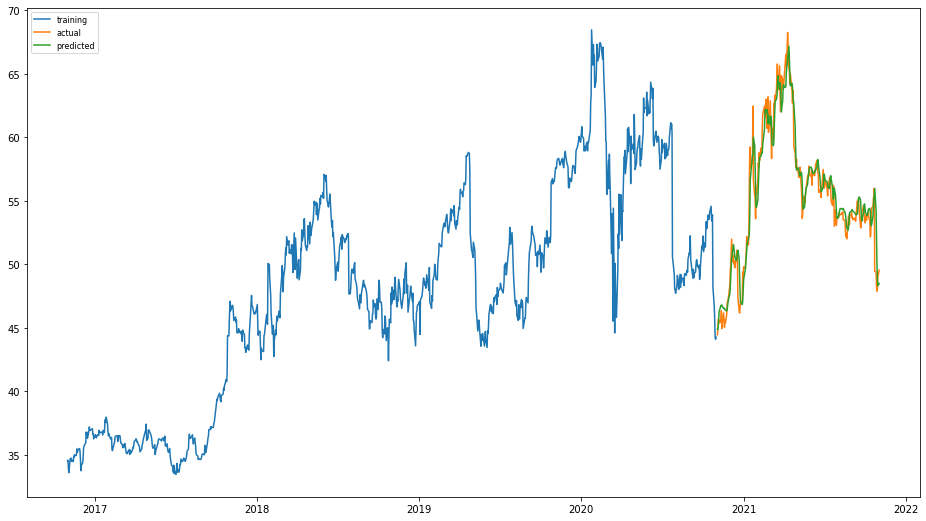

In [42]:
#for plotting
plt.figure(figsize=(16,9))
train = close[:int(len(close_dataset)*0.8)]
valid = close[int(len(close_dataset)*0.8):]
valid['Predictions'] = close_price
plt.plot(train,label='training')
plt.plot(valid.loc[:,:]['INTC'], label='actual')
plt.plot(valid.loc[:,:]['Predictions'], label='predicted')
plt.legend(loc='upper left', fontsize=8)
plt.show()
#plt.plot(valid['Predictions'])


### Forcasting

To predict tomorrow's value, feed into the model the past n(look_back) days’ values and we get tomorrow’s value as output. To get the day after tomorrow’s value, feed-in past n-1 days’ values along with tomorrow’s value and the model output day after tomorrow’s value.
Forecasting for longer duration is not feasible. 

So, let’s forecast a months stock price.

In [45]:
previous_180=close[-180:].values
date = close[-1:].index[0]
dates = []
forecast_days = 60
# changed to 180 days
for i in range(forecast_days):
    previous_180[0] = previous_180[0][-180:]
    scaled_previous_180=sc.fit_transform(previous_180)
    scaled_previous_180 = np.expand_dims(scaled_previous_180, axis=0)

    forecast_price = model.predict(scaled_previous_180)
    forecast_price = sc.inverse_transform(forecast_price)
    
    previous_180 = np.concatenate((previous_180,forecast_price),axis=0)
    previous_180=previous_180[-180:]
    date += + pd.Timedelta(days=1)
    # forecast_df.append([date, forecast_price])
    dates.append(date)


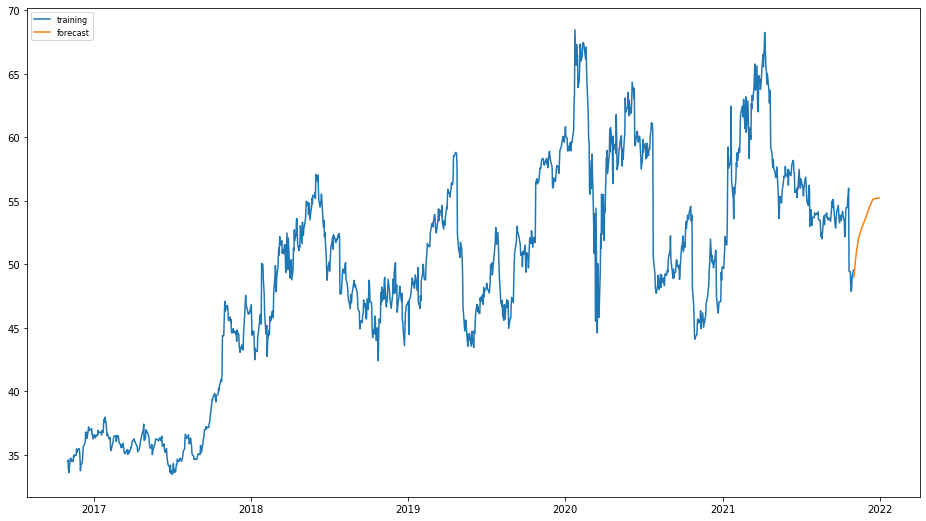

In [46]:
#for plotting
plt.figure(figsize=(16,9))
plt.plot(close,label='training')
plt.plot(dates,previous_180[-forecast_days:].flatten(),label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()
#plt.plot(valid['Predictions'])